In [163]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession,
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed
import tempfile
from pathlib import Path
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
import torch
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import lpips
import cv2

import statistics
import cebra
from cebra import CEBRA

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [172]:
def embdding_cluster(df, cluster_num, random_state):

    data = df.drop(columns = ['category'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=cluster_num, random_state=random_state, algorithm = 'elkan')
    kmeans.fit(data_scaled)
    
    # 获取聚类标签，每个样本对应一个标签
    labels = kmeans.labels_
    # 将标签添加到原始DataFrame中
    data['Cluster'] = labels

    # 记录每个类别的index到列表中
    clusters = []
    for i in range(cluster_num):
        cluster = data[data['Cluster'] == i].index.tolist()
        clusters.append(cluster)
    category = df['category'].tolist()

    # data.drop(columns = ['Cluster'], inplace = True)

    return labels, category

def caculate_metrics(predict_labels, category):
    count = 0
    num_samples = len(predict_labels)
    for i in range(num_samples):
        if predict_labels[i] == category[i]:
            count += 1
    correct_cluster_rate = count / num_samples
    # 计算准确率
    accuracy = accuracy_score(real_category, predict_labels)
    print(f"Accuracy: {accuracy:.2f}")
    # 瞎猜的准确率
    chance = 1 - sum(category) / len(category)
    print(f"Chance:{chance:.2f}")
    print('++++++++++++++++++++++++++')
    # 计算精确率
    precision = precision_score(real_category, predict_labels) 
    print(f"Precision: {precision:.2f}")
    # 计算召回率
    recall = recall_score(real_category, predict_labels)
    print(f"Recall: {recall:.2f}")
    # 计算 F1-score
    f1 = f1_score(real_category, predict_labels)
    print(f"F1-Score: {f1:.2f}")

def average_images(folder_path, image_names):
    # 存储所有读取的图片数组
    image_arrays = []
    
    # 遍历所有指定的图片名
    for name in image_names:
        # 构建完整的文件路径
        file_path = os.path.join(folder_path, f"{name}.png")
        
        # 打开并转换图片为灰度（单通道）
        with Image.open(file_path).convert('L') as img:
            # 将图片转换为numpy数组并添加到列表中
            image_arrays.append(np.array(img))
    
    # 计算所有图片的平均值
    if image_arrays:
        average_array = np.mean(image_arrays, axis=0)
        # 将平均后的数组转换回图片
        average_image = Image.fromarray(np.uint8(average_array))
        # 显示平均图片
        plt.figure(figsize=(3, 3))
        plt.imshow(average_image, cmap='gray')
        plt.axis('off')
        plt.savefig(r'D:\MSC_Project\Graph\average_{}.png'.format(image_names), bbox_inches='tight', pad_inches=0)
        plt.axis('off')  # 关闭坐标轴
        plt.show()
    else:
        print("没有图片可处理。")
    return average_array
        
image_folder = r'C:\Users\Lenovo\Stable_Diffusion\StableDiffusion-PyTorch-main\data\mnist\train\images_135'
tiger = [10, 11, 12, 27]
weedtree = [59, 62, 63, 77, 92, 96, 100, 108]
cheetah = [15, 17, 22, 39]
bear = [0, 1, 2]
bird = [4, 18, 19, 21, 24, 28, 35, 52]
building = [81, 85, 86, 94, 105]
elephant = [8, 9, 34]
landscape = [20, 30, 31, 36, 37, 43, 80]
stone = [72, 84, 104, 106]
leaves = [87, 91, 110]

In [165]:
# Example cache directory path, it determines where downloaded data will be stored
output_dir = r'E:\Neuroscience'
# this path determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
print(cache.get_all_session_types())
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
session_791319847 = cache.get_session_data(791319847)
ns_presentation_ids_791319847 = session_791319847.stimulus_presentations.loc[
    (session_791319847.stimulus_presentations['stimulus_name'] == 'natural_scenes')
].index.values
stimulus_table = session_791319847.get_stimulus_table()

['brain_observatory_1.1', 'functional_connectivity']


In [166]:
session = pd.read_csv(r'E:\Neuroscience\neuropixel_data\stimulus_response(individual_sessions)\session_791319847.csv')
annotation = pd.read_csv(r'E:\Neuroscience\neuropixel_data\annotation\annotation_791319847.csv')

# 取出VI区的神经元
VI_neuron = np.array(annotation[annotation['structure_acronym'].str.startswith('VI')]['cluster_id'])
# 因为有相同的神经元出现在不同脑区，所以部分神经元同时出现在VI的多个脑区内，会被多次采集，要对列表进行去重。转为set再转为list完成去重。
list_VI_neuron = list(set(VI_neuron))
# 保留stimulus_presentation_id列
list_VI_neuron.insert(0, 'stimulus_presentation_id')
VI_session = session[list_VI_neuron]

# 获取每个time bin对应的刺激图像编号
stimulus_table = session_791319847.get_stimulus_table()
frame = stimulus_table[stimulus_table['stimulus_name'] == 'natural_scenes']['frame']
VI_session = pd.merge(frame.astype(int), VI_session, left_on = frame.index, right_on = 'stimulus_presentation_id')

grouped = VI_session.groupby('stimulus_presentation_id')

# 为每个神经元的每个特定位置创建一个新的列名
def flatten_group(group):
    new_row = {}
    # 对于除了'id'和'frame'的每列
    for col in group.columns.drop(['stimulus_presentation_id', 'frame']):
        # 展平每列
        for idx, value in enumerate(group[col].values):
            new_row[f'{col}_{idx+1}'] = value
    new_row['frame'] = group['frame'].iloc[0]  # 也许你想保留第一帧的信息
    return pd.Series(new_row)

# 应用上述函数，展平每个分组
VI_session_flat = grouped.apply(flatten_group)

# 重置索引
VI_session_flat.reset_index(inplace=True)
VI_session_flat.drop(columns = ['stimulus_presentation_id'], inplace = True)

In [167]:
rf_stim_table = session_791319847.stimulus_presentations[session_791319847.stimulus_presentations.stimulus_name == 'natural_scenes']
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping import ReceptiveFieldMapping
rf_mapping = ReceptiveFieldMapping(session_791319847)

### natural scenes and static grating correlation calculation

In [22]:
scene_presentations = session_791319847.get_stimulus_table("natural_scenes")
vi_units = session_791319847.units[session_791319847.units["ecephys_structure_acronym"].str.startswith('VI')]
vi_units = vi_units[vi_units['snr'] >= 1.5]
spikes = session_791319847.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=vi_units.index.values[:]
)

spikes["count"] = np.zeros(spikes.shape[0])
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

design = pd.pivot_table(
    spikes, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)

In [21]:
sg_presentations = session_791319847.get_stimulus_table("static_gratings")
sg_presentations = sg_presentations[(sg_presentations['orientation'] == 0.0) & (sg_presentations['spatial_frequency'] == 0.32)]
spikes_sg = session_791319847.presentationwise_spike_times(
    stimulus_presentation_ids=sg_presentations.index.values,
    unit_ids=vi_units.index.values[:]
)

spikes_sg["count"] = np.zeros(spikes_sg.shape[0])
spikes_sg = spikes_sg.groupby(["stimulus_presentation_id", "unit_id"]).count()

design_sg = pd.pivot_table(
    spikes_sg, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)

In [23]:
pca = PCA(n_components=8)
design = design.reset_index(drop = True)
design_sg = design_sg.reset_index(drop = True)
design['frame'] = VI_session_flat['frame']
design_sg['frame'] = 'static_grating'
design_ns_sg = pd.concat([design, design_sg], axis = 0)
design_ns_sg = design_ns_sg.reset_index(drop = True)
frame_ns_sg = design_ns_sg['frame']
design_ns_sg.drop(columns = ['frame'], inplace = True)
design_ns_sg_projected = pd.DataFrame(pca.fit_transform(design_ns_sg))
design_ns_sg_projected['frame'] = frame_ns_sg


In [ ]:
design_ns_sg_projected_mean = design_ns_sg_projected.groupby('frame').mean()
design_ns_sg_projected_mean = design_ns_sg_projected_mean[1:]
design_mean = design_ns_sg_projected_mean

In [10]:
design_tiger = design_mean.loc[[10, 11, 12, 27]]
design_weedtree = design_mean.loc[[59, 62, 63, 77, 92, 96, 100, 108]]
design_cheetah = design_mean.loc[[15, 17, 22, 39]]
design_bear = design_mean.loc[[0, 1, 2]]
design_bird = design_mean.loc[[4, 18, 19, 21, 24, 28, 35, 52]]
design_building = design_mean.loc[[81, 85, 86, 94, 105]]
design_elephant = design_mean.loc[[8, 9, 34]]
design_landscape = design_mean.loc[[20, 30, 31, 36, 37, 43, 80]]
design_stone = design_mean.loc[[72, 84, 104, 106]]
design_leaves = design_mean.loc[[87, 91, 110]]
design_sg = design_mean.loc['static_grating']

design_tiger_mean_df = pd.DataFrame(design_tiger.mean()).T
design_weedtree_mean_df = pd.DataFrame(design_weedtree.mean()).T
design_cheetah_mean_df = pd.DataFrame(design_cheetah.mean()).T
design_bear_mean_df = pd.DataFrame(design_bear.mean()).T
design_bird_mean_df = pd.DataFrame(design_bird.mean()).T
design_building_mean_df = pd.DataFrame(design_building.mean()).T
design_elephant_mean_df = pd.DataFrame(design_elephant.mean()).T
design_landscape_mean_df = pd.DataFrame(design_landscape.mean()).T
design_stone_mean_df = pd.DataFrame(design_stone.mean()).T
design_leaves_mean_df = pd.DataFrame(design_leaves.mean()).T
design_sg_df = pd.DataFrame(design_sg).T

design_mean_category = pd.concat([design_tiger_mean_df, design_sg_df, design_cheetah_mean_df,
                                         design_bear_mean_df, design_bird_mean_df, design_building_mean_df,
                                         design_elephant_mean_df, design_landscape_mean_df, design_stone_mean_df,
                                         design_leaves_mean_df, design_weedtree_mean_df], ignore_index = True, )
design_mean_category.index = ['tiger', 'static_grating', 'cheetah', 'bear', 'bird', 'building', 'elephant', 'landscape', 'stone', 'leaves', 'weedtree']

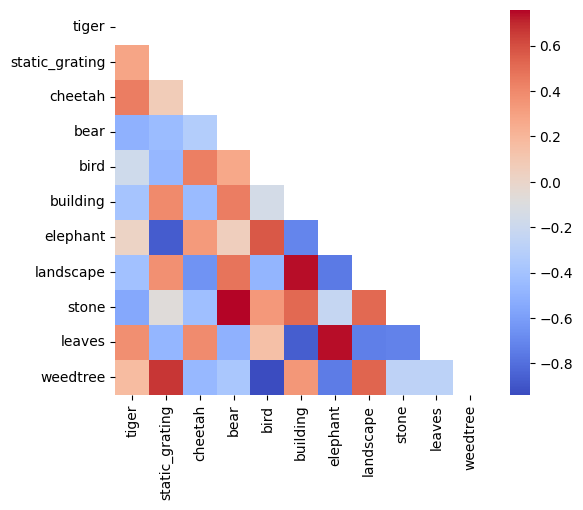

In [162]:
corr_matrix = design_mean_category.T.corr()
# 掩盖对角线和下三角
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 绘制热力图
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f")
# plt.title("Correlation of the mean neural activity when mouse watch different objects")
plt.savefig(r'D:\MSC_Project\Graph\Correlation of the mean neural activity.png')
plt.show()

In [31]:
embedding_pca = design_ns_sg_projected

### SVM to inquiry if rat can distinguish different object

In [94]:
def svm_classifier(embedding_df):
    X = embedding_df.iloc[:, :-1]  # 选择除了最后一列的所有列作为特征
    y = embedding_df.iloc[:, -1]   # 最后一列作为标签
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 创建 SVM 分类器
    svm_model = SVC(kernel='rbf')
    # 5折交叉验证
    accuracy_scores = cross_val_score(svm_model, X, y, cv=5)
    print("五折交叉验证的标准差:", np.std(accuracy_scores))
    print("平均准确率: {:.2f}".format(accuracy_scores.mean()))

    return accuracy_scores.mean(), np.std(accuracy_scores)

In [120]:
embedding_df_tiger = embedding_pca[embedding_pca['frame'].isin([10, 11, 12, 27])]
embedding_df_tiger['category'] = 'tiger'
embedding_df_elephant = embedding_pca[embedding_pca['frame'].isin([8, 9, 34])]
embedding_df_elephant['category'] = 'elephant'
embedding_df_cheetah = embedding_pca[embedding_pca['frame'].isin([15, 17, 22, 39])]
embedding_df_cheetah['category'] = 'cheetah'
embedding_df_weedtree = embedding_pca[embedding_pca['frame'].isin([59, 62, 63, 77, 92, 96, 100, 108, 109])]
embedding_df_weedtree['category'] = 'weed_tree'
embedding_df_bear = embedding_pca[embedding_pca['frame'].isin([0, 1, 2])]
embedding_df_bear['category'] = 'bear'
embedding_df_bird = embedding_pca[embedding_pca['frame'].isin([4, 18, 19, 21, 24, 28, 35, 52])]
embedding_df_bird['category'] = 'bird'
embedding_df_building = embedding_pca[embedding_pca['frame'].isin([81, 85, 86, 94, 105])]
embedding_df_building['category'] = 'building'
embedding_df_landscape = embedding_pca[embedding_pca['frame'].isin([20, 30, 31, 36, 37, 43, 80])]
embedding_df_landscape['category'] = 'landscape'
embedding_df_stone = embedding_pca[embedding_pca['frame'].isin([72, 84, 104, 106])]
embedding_df_stone['category'] = 'stone'
embedding_df_leaves = embedding_pca[embedding_pca['frame'].isin([87, 91, 110])]
embedding_df_leaves['category'] = 'leaves'

embedding_df_sg = embedding_pca[embedding_pca['frame'] == 'static_grating']
embedding_df_sg['category'] = 'static_grating'

In [147]:
embedding_df_tiger_elephant = pd.concat([embedding_df_tiger, embedding_df_elephant], axis = 0)
embedding_df_tiger_elephant.drop(columns = ['frame'], inplace = True)

print("tiger and elephant: ")
acc_tiger_elephant, std_tiger_elephant = svm_classifier(embedding_df_tiger_elephant)
chance_tiger_elephant = 4/7
print("乱猜最高准确率: {:.2f}".format(chance_tiger_elephant))
acc_diff = acc_tiger_elephant - chance_tiger_elephant
print("准确率差值: {:.2f}".format(acc_diff))

# predict_labels, category = embdding_cluster(embedding_df_tiger_elephant, 2, random_state = 9)
# real_category = np.array([0 if x == 'tiger' else 1 for x in category])
# caculate_metrics(predict_labels, real_category)

tiger and elephant: 
五折交叉验证的标准差: 0.06426983930972566
平均准确率: 0.71
乱猜最高准确率: 0.57
准确率差值: 0.13


In [148]:
embedding_df_tiger_cheetah = pd.concat([embedding_df_tiger, embedding_df_cheetah], axis = 0)
embedding_df_tiger_cheetah.drop(columns = ['frame'], inplace = True)

print("tiger and cheetah: ")
acc_tiger_cheetah, std_tiger_cheetach = svm_classifier(embedding_df_tiger_cheetah)
chance_tiger_cheetah = 4/8
print("乱猜最高准确率: {:.2f}".format(chance_tiger_cheetah))
acc_diff = acc_tiger_cheetah - chance_tiger_cheetah
print("准确率差值: {:.2f}".format(acc_diff))

tiger and cheetah: 
五折交叉验证的标准差: 0.05396758286230727
平均准确率: 0.64
乱猜最高准确率: 0.50
准确率差值: 0.14


In [149]:
embedding_df_weedtree_cheetah = pd.concat([embedding_df_weedtree, embedding_df_cheetah], axis = 0)
embedding_df_weedtree_cheetah.drop(columns = ['frame'], inplace = True)

print("weedtree and cheetah: ")
acc_weedtree_cheetah, std_weedtree_cheetach = svm_classifier(embedding_df_weedtree_cheetah)
chance_weedtree_cheetah = 9/15
print("乱猜最高准确率: {:.2f}".format(chance_weedtree_cheetah))
acc_diff = acc_weedtree_cheetah - chance_weedtree_cheetah
print("准确率差值: {:.2f}".format(acc_diff))


weedtree and cheetah: 
五折交叉验证的标准差: 0.03561795970089302
平均准确率: 0.79
乱猜最高准确率: 0.60
准确率差值: 0.19


In [150]:
embedding_df_stone_building = pd.concat([embedding_df_stone, embedding_df_building], axis = 0)
embedding_df_stone_building.drop(columns = ['frame'], inplace = True)

print("stone and building: ")
acc_stone_building, std_stone_building = svm_classifier(embedding_df_stone_building)
chance_stone_building = 5/9
print("乱猜最高准确率: {:.2f}".format(chance_stone_building))
acc_diff = acc_stone_building - chance_stone_building
print("准确率差值: {:.2f}".format(acc_diff))

stone and building: 
五折交叉验证的标准差: 0.029313124351717578
平均准确率: 0.65
乱猜最高准确率: 0.56
准确率差值: 0.10


In [159]:
embedding_df_bird_landscape = pd.concat([embedding_df_bird, embedding_df_landscape], axis = 0)
embedding_df_bird_landscape.drop(columns = ['frame'], inplace = True)

print("bird and landscape: ")
acc_bird_landscape, std_bird_landscape = svm_classifier(embedding_df_bird_landscape)
chance_bird_landscape = 8/15
print("乱猜最高准确率: {:.2f}".format(chance_bird_landscape))
acc_diff = acc_bird_landscape - chance_bird_landscape
print("准确率差值: {:.2f}".format(acc_diff))

bird and landscape: 
五折交叉验证的标准差: 0.04513682901282869
平均准确率: 0.75
乱猜最高准确率: 0.53
准确率差值: 0.22


In [157]:
embedding_df_bird_building = pd.concat([embedding_df_bird, embedding_df_building], axis = 0)
embedding_df_bird_building.drop(columns = ['frame'], inplace = True)

print("bird and building: ")
acc_bird_building, std_bird_building = svm_classifier(embedding_df_bird_building)
chance_bird_building = 8/14
print("乱猜最高准确率: {:.2f}".format(chance_bird_building))
acc_diff = acc_bird_building - chance_bird_building
print("准确率差值: {:.2f}".format(acc_diff))

bird and building: 
五折交叉验证的标准差: 0.03521699428387567
平均准确率: 0.67
乱猜最高准确率: 0.57
准确率差值: 0.10


In [160]:
embedding_df_stone_cheetah = pd.concat([embedding_df_stone, embedding_df_cheetah], axis = 0)
embedding_df_stone_cheetah.drop(columns = ['frame'], inplace = True)

print("stone and cheetah: ")
acc_stone_cheetah, std_stone_cheetah = svm_classifier(embedding_df_stone_cheetah)
chance_stone_cheetah = 8/14
print("乱猜最高准确率: {:.2f}".format(chance_stone_cheetah))
acc_diff = acc_stone_cheetah - chance_stone_cheetah
print("准确率差值: {:.2f}".format(acc_diff))

stone and cheetah: 
五折交叉验证的标准差: 0.05396758286230725
平均准确率: 0.79
乱猜最高准确率: 0.57
准确率差值: 0.22


In [114]:
embedding_df_sg_cheetah = pd.concat([embedding_df_sg, embedding_df_cheetah], axis = 0)
embedding_df_sg_cheetah.drop(columns = ['frame'], inplace = True)

print("cheetah and static grating:")
acc_sg_cheetah, std_sg_cheetach = svm_classifier(embedding_df_sg_cheetah)
chance_sg_cheetah = 300 / (192+300)
print("乱猜最高准确率: {:.2f}".format(chance_sg_cheetah))
acc_diff = acc_sg_cheetah - chance_sg_cheetah
print("准确率差值: {:.2f}".format(acc_diff))

cheetah and static grating:
五折交叉验证的标准差: 0.05710502941736893
平均准确率: 0.86
乱猜最高准确率: 0.61
准确率差值: 0.25


In [115]:
embedding_df_weedtree_sg = pd.concat([embedding_df_weedtree, embedding_df_sg], axis = 0)
embedding_df_weedtree_sg.drop(columns = ['frame'], inplace = True)

print("weedtree and static grating:")
acc_sg_weedtree, std_sg_weedtree = svm_classifier(embedding_df_weedtree_sg)
chance_sg_weedtree = 450 / (192+450)
print("乱猜最高准确率: {:.2f}".format(chance_sg_weedtree))
acc_diff = acc_sg_weedtree - chance_sg_weedtree
print("准确率差值: {:.2f}".format(acc_diff))

weedtree and static grating:
五折交叉验证的标准差: 0.04115147553638916
平均准确率: 0.83
乱猜最高准确率: 0.70
准确率差值: 0.13


In [127]:
embedding_df_bear_sg = pd.concat([embedding_df_bear, embedding_df_sg], axis = 0)
embedding_df_bear_sg.drop(columns = ['frame'], inplace = True)

print("bear and static grating:")
acc_sg_bear, std_sg_bear = svm_classifier(embedding_df_bear_sg)
chance_sg_bear = 192 / (192+150)
print("乱猜最高准确率: {:.2f}".format(chance_sg_bear))
acc_diff = acc_sg_bear - chance_sg_bear
print("准确率差值: {:.2f}".format(acc_diff))

bear and static grating:
五折交叉验证的标准差: 0.03953077758885623
平均准确率: 0.90
乱猜最高准确率: 0.56
准确率差值: 0.34


In [128]:
embedding_df_bird_sg = pd.concat([embedding_df_bird, embedding_df_sg], axis = 0)
embedding_df_bird_sg.drop(columns = ['frame'], inplace = True)

print("bird and static grating:")
acc_sg_bird, std_sg_bird = svm_classifier(embedding_df_bird_sg)
chance_sg_bird = 400 / (192+400)
print("乱猜最高准确率: {:.2f}".format(chance_sg_bird))
acc_diff = acc_sg_bird - chance_sg_bird
print("准确率差值: {:.2f}".format(acc_diff))

bird and static grating:
五折交叉验证的标准差: 0.0354449503234228
平均准确率: 0.91
乱猜最高准确率: 0.68
准确率差值: 0.23


In [129]:
embedding_df_stone_sg = pd.concat([embedding_df_stone, embedding_df_sg], axis = 0)
embedding_df_stone_sg.drop(columns = ['frame'], inplace = True)

print("stone and static grating:")
acc_sg_stone, std_sg_stone = svm_classifier(embedding_df_stone_sg)
chance_sg_stone = 200 / (192+200)
print("乱猜最高准确率: {:.2f}".format(chance_sg_stone))
acc_diff = acc_sg_stone - chance_sg_stone
print("准确率差值: {:.2f}".format(acc_diff))

stone and static grating:
五折交叉验证的标准差: 0.03678143700935213
平均准确率: 0.91
乱猜最高准确率: 0.51
准确率差值: 0.40


In [142]:
embedding_df_leaves_sg = pd.concat([embedding_df_leaves, embedding_df_sg], axis = 0)
embedding_df_leaves_sg.drop(columns = ['frame'], inplace = True)

print("leaves and static grating:")
acc_sg_leaves, std_sg_leaves = svm_classifier(embedding_df_leaves_sg)
chance_sg_leaves = 192 / (192+150)
print("乱猜最高准确率: {:.2f}".format(chance_sg_leaves))
acc_diff = acc_sg_leaves - chance_sg_leaves
print("准确率差值: {:.2f}".format(acc_diff))

leaves and static grating:
五折交叉验证的标准差: 0.03554220479485466
平均准确率: 0.90
乱猜最高准确率: 0.56
准确率差值: 0.34


In [132]:
embedding_df_landscape_sg = pd.concat([embedding_df_landscape, embedding_df_sg], axis = 0)
embedding_df_landscape_sg.drop(columns = ['frame'], inplace = True)

print("landscape and static grating:")
acc_sg_landscape, std_sg_leaves = svm_classifier(embedding_df_landscape_sg)
chance_sg_landscape = 350 / (192+350)
print("乱猜最高准确率: {:.2f}".format(chance_sg_landscape))
acc_diff = acc_sg_leaves - chance_sg_landscape
print("准确率差值: {:.2f}".format(acc_diff))

landscape and static grating:
五折交叉验证的标准差: 0.021396073051302582
平均准确率: 0.90
乱猜最高准确率: 0.65
准确率差值: 0.27


In [136]:
embedding_df_tiger_sg = pd.concat([embedding_df_tiger, embedding_df_sg], axis = 0)
embedding_df_tiger_sg.drop(columns = ['frame'], inplace = True)

print("tiger and static grating:")
acc_sg_tiger, std_sg_tiger = svm_classifier(embedding_df_tiger_sg)
chance_sg_tiger = 200 / (192+200)
print("乱猜最高准确率: {:.2f}".format(chance_sg_tiger))
acc_diff = acc_sg_tiger - chance_sg_tiger
print("准确率差值: {:.2f}".format(acc_diff))

tiger and static grating:
五折交叉验证的标准差: 0.014403520422594034
平均准确率: 0.85
乱猜最高准确率: 0.51
准确率差值: 0.34


In [138]:
embedding_df_building_sg = pd.concat([embedding_df_building, embedding_df_sg], axis = 0)
embedding_df_building_sg.drop(columns = ['frame'], inplace = True)

print("building and static grating:")
acc_sg_building, std_sg_building = svm_classifier(embedding_df_building_sg)
chance_sg_building = 250 / (192+250)
print("乱猜最高准确率: {:.2f}".format(chance_sg_building))
acc_diff = acc_sg_building - chance_sg_building
print("准确率差值: {:.2f}".format(acc_diff))

building and static grating:
五折交叉验证的标准差: 0.054533737211879936
平均准确率: 0.88
乱猜最高准确率: 0.57
准确率差值: 0.31


In [141]:
embedding_df_elephant_sg = pd.concat([embedding_df_elephant, embedding_df_sg], axis = 0)
embedding_df_elephant_sg.drop(columns = ['frame'], inplace = True)

print("elephant and static grating:")
acc_sg_elephant, std_sg_elephant = svm_classifier(embedding_df_elephant_sg)
chance_sg_elephant = 150 / (192+150)
print("乱猜最高准确率: {:.2f}".format(chance_sg_elephant))
acc_diff = acc_sg_elephant - chance_sg_elephant
print("准确率差值: {:.2f}".format(acc_diff))

elephant and static grating:
五折交叉验证的标准差: 0.04147846486007538
平均准确率: 0.91
乱猜最高准确率: 0.44
准确率差值: 0.47


### only natural scenes correlation calculation

In [51]:
# 加上frame列, 按照frame求平均
design = design.reset_index(drop = True)
design['frame'] = VI_session_flat['frame']
design_mean = design.groupby('frame').mean()
design_mean = design_mean[1:]

In [65]:
design_tiger = design_mean.loc[[10, 11, 12, 27]]
design_weedtree = design_mean.loc[[59, 62, 63, 77, 92, 96, 100, 108]]
design_cheetah = design_mean.loc[[15, 17, 22, 39]]
design_bear = design_mean.loc[[0, 1, 2]]
design_bird = design_mean.loc[[4, 18, 19, 21, 24, 28, 35, 52]]
design_building = design_mean.loc[[81, 85, 86, 94, 105]]
design_elephant = design_mean.loc[[8, 9, 34]]
design_landscape = design_mean.loc[[20, 30, 31, 36, 37, 43, 80]]
design_stone = design_mean.loc[[72, 84, 104, 106]]
design_leaves = design_mean.loc[[87, 91, 110]]

design_tiger_mean_df = pd.DataFrame(design_tiger.mean()).T
design_weedtree_mean_df = pd.DataFrame(design_weedtree.mean()).T
design_cheetah_mean_df = pd.DataFrame(design_cheetah.mean()).T
design_bear_mean_df = pd.DataFrame(design_bear.mean()).T
design_bird_mean_df = pd.DataFrame(design_bird.mean()).T
design_building_mean_df = pd.DataFrame(design_building.mean()).T
design_elephant_mean_df = pd.DataFrame(design_elephant.mean()).T
design_landscape_mean_df = pd.DataFrame(design_landscape.mean()).T
design_stone_mean_df = pd.DataFrame(design_stone.mean()).T
design_leaves_mean_df = pd.DataFrame(design_leaves.mean()).T

In [176]:
design_mean_category = pd.concat([design_tiger_mean_df, design_weedtree_mean_df, design_cheetah_mean_df,
                                         design_bear_mean_df, design_bird_mean_df, design_building_mean_df,
                                         design_elephant_mean_df, design_landscape_mean_df, design_stone_mean_df,
                                         design_leaves_mean_df], ignore_index = True, )
design_mean_category.index = ['tiger', 'weedtree', 'cheetah', 'bear', 'bird', 'building', 'elephant', 'landscape', 'stone', 'leaves']

In [177]:
# 创建 PCA 实例，降维到 8 维，计算得知8维可以保留97%的方差。
# 警惕维度诅咒，在高维空间会出现距离聚集效应，数据点之间距离变近，相似度变高，所以要降维。且高维时KNN等基于距离的算法都会变得极不稳定。
pca = PCA(n_components=8)
design_mean_category_projected = pca.fit_transform(design_mean_category)

In [178]:
design_mean_category_projected = pd.DataFrame(design_mean_category_projected)
design_mean_category_projected.index = ['tiger', 'weedtree', 'cheetah', 'bear', 'bird', 'building', 'elephant', 'landscape', 'stone', 'leaves']

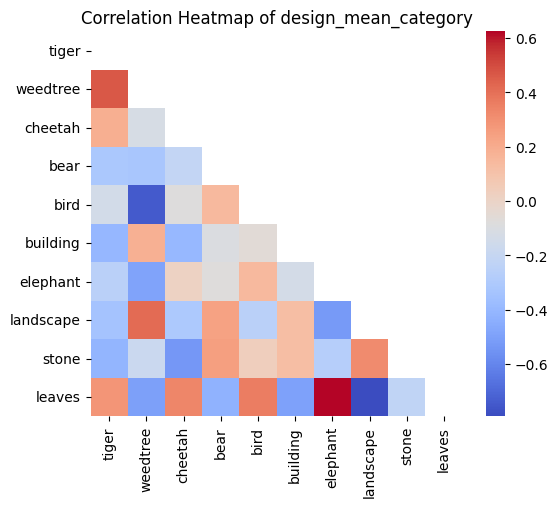

In [179]:
corr_matrix = design_mean_category_projected.T.corr()
# 掩盖对角线和下三角
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 绘制热力图
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap of design_mean_category")
plt.show()

### attention weight calculation

In [212]:
rf_units = []
for x in design_mean_category.columns.values:
    rf_units.append(rf_mapping.get_receptive_field(x))

In [213]:
def calculate_weight_matrix(category_str):
    weights = np.array(design_mean_category.loc[category_str])
    # 归一化权重
    weights = weights / np.sum(weights)
    # 验证数组长度是否匹配
    assert len(weights) == len(rf_units), "The lengths of weights_tiger and rf_units must match."
    
    # 初始化一个加权矩阵，维度与 rf_units 中的矩阵相同
    weighted_matrix = np.zeros_like(rf_units[0]).astype('float64')
    
    # 遍历权重和单位矩阵列表，计算加权和
    for weight, unit in zip(weights, rf_units):
        weighted_matrix += weight * unit
    
    # 归一化 weighted_matrix 到 0-1 范围
    min_val = np.min(weighted_matrix)
    max_val = np.max(weighted_matrix)
    normalized_matrix = (weighted_matrix - min_val) / (max_val - min_val)
    # 创建一个7x7的全1矩阵
    
    ones_block = np.ones((15, 15))
    # 使用克罗内克积扩大矩阵
    expanded_weight_matrix = np.kron(normalized_matrix, ones_block)

    return expanded_weight_matrix

def normlize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)    
    return normalized_image

In [214]:
weight_tiger_matrix = calculate_weight_matrix('tiger')
weight_weedtree_matrix = calculate_weight_matrix('weedtree')
weight_elephant_matrix = calculate_weight_matrix('elephant')
weight_cheetah_matrix = calculate_weight_matrix('cheetah')
weight_stone_matrix = calculate_weight_matrix('stone')
weight_building_matrix = calculate_weight_matrix('building')
weight_bear_matrix = calculate_weight_matrix('bear')
weight_leaves_matrix = calculate_weight_matrix('leaves')
weight_bird_matrix = calculate_weight_matrix('bird')
weight_landscape_matrix = calculate_weight_matrix('landscape')

### average image calculation

In [27]:
image1.dtype

dtype('uint8')

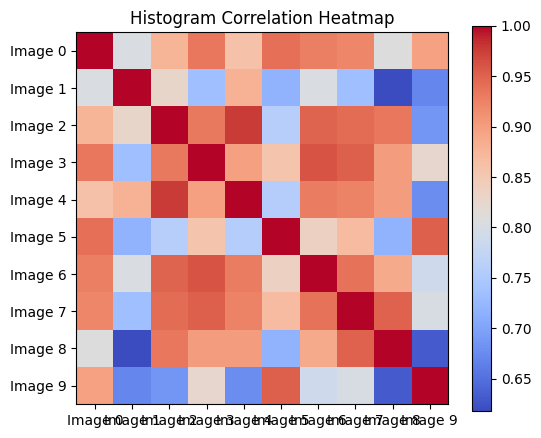

In [32]:
histograms = []
for img in average_images_class:
    if img.dtype != np.uint8:  # 检查数据类型，必要时进行转换
        img = img.astype(np.uint8)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    histograms.append(hist)

# 归一化直方图
normalized_histograms = [cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) for hist in histograms]

# 计算直方图的相关性矩阵
num_images = len(normalized_histograms)
similarity_matrix = np.zeros((num_images, num_images))

for i in range(num_images):
    for j in range(num_images):
        similarity_matrix[i, j] = cv2.compareHist(normalized_histograms[i], normalized_histograms[j], cv2.HISTCMP_CORREL)

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(similarity_matrix, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.title('Histogram Correlation Heatmap')
plt.xticks(range(num_images), labels=[f'Image {i}' for i in range(num_images)])
plt.yticks(range(num_images), labels=[f'Image {i}' for i in range(num_images)])
plt.show()

In [ ]:
average_images_class = [average_tiger, average_weedtree, average_cheetah,
                            average_bear, average_bird, average_building,
                            average_elephant, average_landscape, average_stone,
                            average_leaves]

In [19]:
image1 = np.array(average_building, dtype=np.uint8)  # 确保数据类型为 uint8
image2 = np.array(average_bird, dtype=np.uint8)  # 确保数据类型为 uint8

# 计算两张图片的直方图
hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

# 归一化直方图
cv2.normalize(hist1, hist1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
cv2.normalize(hist2, hist2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# 计算直方图的相似度
correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
intersect = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

print(f"Correlation: {correlation}")
print(f"Chi-Square: {chi_square}")
print(f"Intersection: {intersect}")
print(f"Bhattacharyya Distance: {bhattacharyya}")

Correlation: 0.7576482484630167
Chi-Square: 32.05257555771152
Intersection: 54.04890791606158
Bhattacharyya Distance: 0.3119403107345391


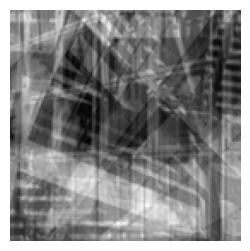

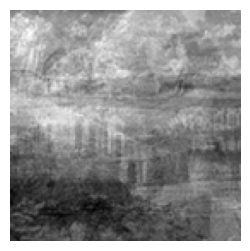

In [13]:
average_building = average_images(image_folder, building)
average_landscape = average_images(image_folder, landscape)

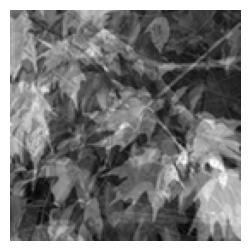

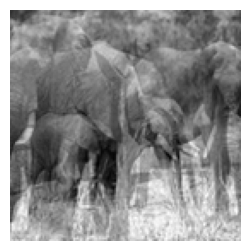

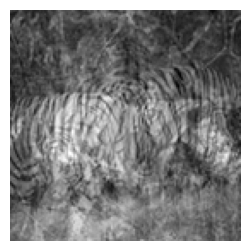

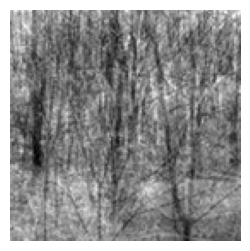

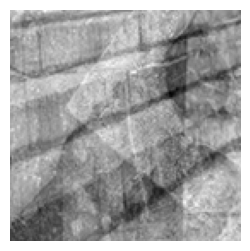

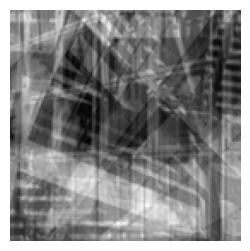

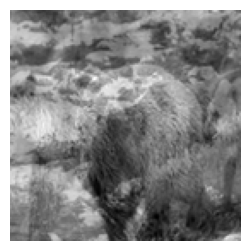

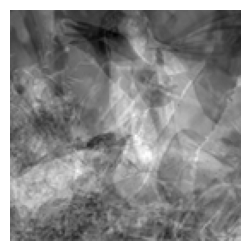

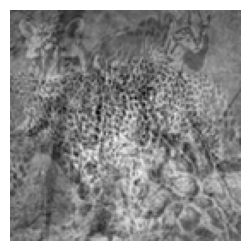

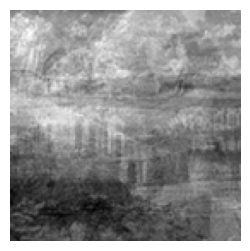

In [173]:
average_leaves = average_images(image_folder, leaves)
average_elephant = average_images(image_folder, elephant)
average_tiger = average_images(image_folder, tiger)
average_weedtree = average_images(image_folder, weedtree)
average_stone = average_images(image_folder, stone)
average_building = average_images(image_folder, building)
average_bear = average_images(image_folder, bear)
average_bird = average_images(image_folder, bird)
average_cheetah = average_images(image_folder, cheetah)
average_landscape = average_images(image_folder, landscape)

### image correlation calculation

In [216]:
attention_average_leaves = normlize_image(average_leaves * weight_leaves_matrix)
attention_average_elephant = normlize_image(average_elephant * weight_elephant_matrix)
attention_average_tiger = normlize_image(average_tiger * weight_tiger_matrix)
attention_average_weedtree = normlize_image(average_weedtree * weight_weedtree_matrix)
attention_average_cheetah = normlize_image(average_cheetah * weight_cheetah_matrix)
attention_average_stone = normlize_image(average_stone * weight_stone_matrix)
attention_average_building = normlize_image(average_building * weight_building_matrix)
attention_average_landscape = normlize_image(average_landscape * weight_landscape_matrix)
attention_average_bird = normlize_image(average_bird * weight_bird_matrix)
attention_average_bear = normlize_image(average_bear * weight_bear_matrix)

In [30]:
average_images_class = [average_tiger, average_weedtree, average_cheetah,
                            average_bear, average_bird, average_building,
                            average_elephant, average_landscape, average_stone,
                            average_leaves]
attention_average_images = [attention_average_tiger, attention_average_weedtree, attention_average_cheetah,
                            attention_average_bear, attention_average_bird, attention_average_building,
                            attention_average_elephant, attention_average_landscape, attention_average_stone,
                            attention_average_leaves]

# 图片转为tensor
def ensure_3d(image):
    if len(image.shape) == 2:  # 如果是2维的灰度图像，增加一个颜色通道维度
        image = np.expand_dims(image, axis=2)
    return image
attention_average_tensors = [lpips.im2tensor(ensure_3d(image)) for image in attention_average_images]


NameError: name 'attention_average_tiger' is not defined

In [269]:
attention_average_images = [average_tiger, average_weedtree, average_cheetah,
                            average_bear, average_bird, average_building,
                            average_elephant, average_landscape, average_stone,
                            average_leaves]


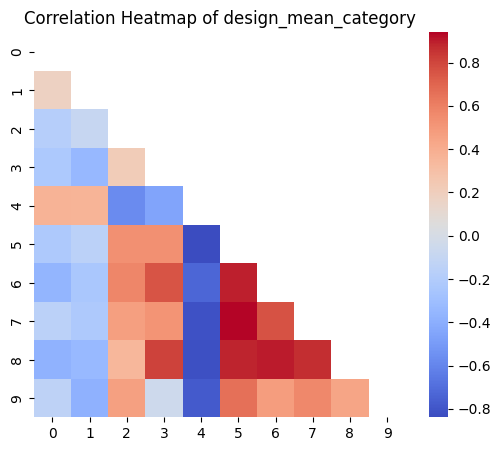

In [359]:
corr_matrix = design_mean_10_projected.T.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# 绘制热力图
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap of design_mean_category")
plt.show()

In [363]:
image_folder = r"C:\Users\Lenovo\Stable_Diffusion\StableDiffusion-PyTorch-main\data\mnist\train\images_135_10"
# 获取文件夹中所有图片的路径并按顺序排序
image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))])
# 确保只有10张图片
if len(image_paths) != 10:
    raise ValueError("文件夹中必须包含10张图片。")
# 将图片加载为张量
def load_image_as_tensor(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    image = lpips.im2tensor(image)
    return image

def load_image_as_array(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    return image
    
# 加载并转换10张图片
image_tensors = [load_image_as_tensor(img_path) for img_path in image_paths]
image_arrs = [load_image_as_array(img_path) for img_path in image_paths]

In [336]:
image_arrs = image_arrs*weight_tiger_matrix
image_arrs = [normlize_image(x) for x in image_arrs]
image_tensors = [lpips.im2tensor(ensure_3d(image)) for image in image_arrs]

In [364]:
def ssim_compute(image_arrs):
    # 初始化SSIM矩阵
    ssim_matrix = np.zeros((len(image_arrs), len(image_arrs)))
    for i in range(len(image_arrs)):
        for j in range(i + 1, len(image_arrs)):  # 只计算上三角部分
            ssim_value = ssim(image_arrs[i], image_arrs[j], data_range = 1)
            ssim_matrix[i, j] = ssim_value
            ssim_matrix[j, i] = ssim_value  # SSIM是对称的
    mask = np.triu(np.ones_like(ssim_matrix, dtype=bool))
    
    # 显示热力图
    plt.figure(figsize=(6, 5))
    sns.heatmap(ssim_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f")
    # plt.imshow(ssim_matrix, interpolation='nearest', cmap='viridis')  # 使用viridis颜色映射增强可读性
    plt.title('SSIM Index Matrix')
    plt.xticks(np.arange(len(image_arrs)), rotation=90, ha='right')  # 设置横坐标标签并旋转以便阅读
    plt.yticks(np.arange(len(image_arrs)), rotation=0)
    plt.show()

In [368]:
def lpips_compute(image_tensors):
    # 初始化LPIPS矩阵
    lpips_matrix = np.zeros((len(image_tensors), len(image_tensors)))
    loss_fn = lpips.LPIPS(net='alex') 
    # 计算LPIPS矩阵
    for i in range(len(image_tensors)):
        for j in range(i + 1, len(image_tensors)):  # 只计算上三角部分
            lpips_value = loss_fn.forward(image_tensors[i], image_tensors[j])
            lpips_matrix[i, j] = lpips_value
            lpips_matrix[j, i] = lpips_value  
    mask = np.triu(np.ones_like(lpips_matrix, dtype=bool))
    # 显示热力图
    plt.figure(figsize=(6, 5))
    sns.heatmap(lpips_matrix, mask=mask, cmap='coolwarm_r', annot=False, fmt=".2f")
    # plt.imshow(ssim_matrix, interpolation='nearest', cmap='viridis')  # 使用viridis颜色映射增强可读性
    plt.title('LPIPS Index Matrix')
    plt.xticks(np.arange(len(image_tensors)), rotation=90, ha='right')  # 设置横坐标标签并旋转以便阅读
    plt.yticks(np.arange(len(image_tensors)), rotation=0)
    plt.show()

### 计算图像LPIPS相似性 

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Anaconda\Lib\site-packages\lpips\weights\v0.1\vgg.pth


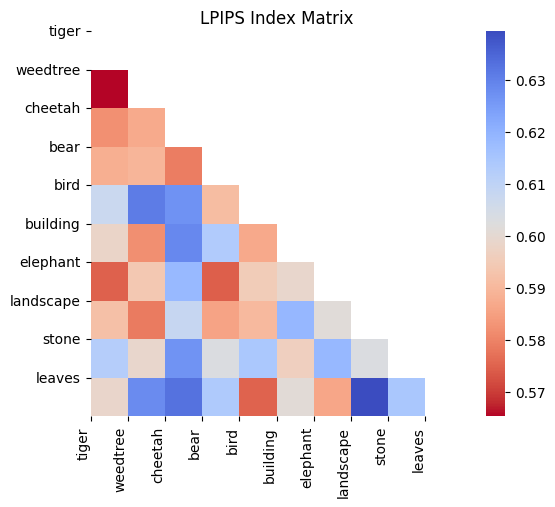

In [270]:
# 图片转为tensor
def ensure_3d(image):
    if len(image.shape) == 2:  # 如果是2维的灰度图像，增加一个颜色通道维度
        image = np.expand_dims(image, axis=2)
    return image
attention_average_tensors = [lpips.im2tensor(ensure_3d(image)) for image in attention_average_images]

# 初始化LPIPS矩阵
lpips_matrix = np.zeros((len(attention_average_tensors), len(attention_average_tensors)))
loss_fn = lpips.LPIPS(net='vgg') 
# 计算LPIPS矩阵
for i in range(len(attention_average_tensors)):
    for j in range(i + 1, len(attention_average_tensors)):  # 只计算上三角部分
        lpips_value = loss_fn.forward(attention_average_tensors[i], attention_average_tensors[j])
        lpips_matrix[i, j] = lpips_value
        lpips_matrix[j, i] = lpips_value  

labels = ['tiger', 'weedtree', 'cheetah', 'bear', 'bird', 'building', 'elephant', 'landscape', 'stone', 'leaves']

# 掩盖对角线和下三角
mask = np.triu(np.ones_like(lpips_matrix, dtype=bool))

# 显示热力图
plt.figure(figsize=(6, 5))
sns.heatmap(lpips_matrix, mask=mask, cmap='coolwarm_r', annot=False, fmt=".2f")
# plt.imshow(ssim_matrix, interpolation='nearest', cmap='viridis')  # 使用viridis颜色映射增强可读性
plt.title('LPIPS Index Matrix')
plt.xticks(np.arange(len(attention_average_tensors)), labels, rotation=90, ha='right')  # 设置横坐标标签并旋转以便阅读
plt.yticks(np.arange(len(attention_average_tensors)), labels, rotation=0)
plt.show()

### 计算图像SSIM相似性

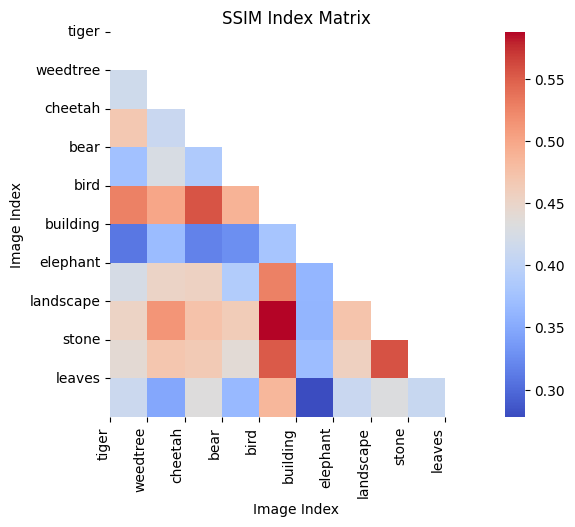

In [261]:
# 初始化SSIM矩阵
ssim_matrix = np.zeros((len(attention_average_images), len(attention_average_images)))

# 计算SSIM矩阵
for i in range(len(attention_average_images)):
    for j in range(i + 1, len(attention_average_images)):  # 只计算上三角部分
        ssim_value = ssim(attention_average_images[i], attention_average_images[j], data_range=1)
        ssim_matrix[i, j] = ssim_value
        ssim_matrix[j, i] = ssim_value  # SSIM是对称的

labels = ['tiger', 'weedtree', 'cheetah', 'bear', 'bird', 'building', 'elephant', 'landscape', 'stone', 'leaves']

# 掩盖对角线和下三角
mask = np.triu(np.ones_like(ssim_matrix, dtype=bool))

# 显示热力图
plt.figure(figsize=(6, 5))
sns.heatmap(ssim_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f")
# plt.imshow(ssim_matrix, interpolation='nearest', cmap='viridis')  # 使用viridis颜色映射增强可读性
plt.title('SSIM Index Matrix')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.xticks(np.arange(len(attention_average_images)), labels, rotation=90, ha='right')  # 设置横坐标标签并旋转以便阅读
plt.yticks(np.arange(len(attention_average_images)), labels, rotation=0)
plt.show()